# Datashader on Colab

This notebook is part of [the single_cell_on_colab repo](https://github.com/reconstrue/single_cell_on_colab). 

The repo is designed to work with large single cell transcriptomic datasets – large referring to datasets with over one million cells. That implies 2D scatter plots plotting over one million data points. In Python on Colab, a great solution for actually handling that many datapoints is [Datashader](https://datashader.org/). 

This notebook exercised Datashader with some single cell data. This project's deploy context is explicitly constrained to Colab. As such interactive user interface is dialed in for Colab. E.g. Bokeh works well with Datashader and comes pre-installed on Colab (implying that Google has worked out issues specific to getting Bokeh to work well with Colab's idiosyncracies).


## Legal

# <img src="http://reconstrue.com/assets/images/reconstrue_logo_brandmark.svg" width="42px" align="top" /> **Reconstrue**


This code is [licensed by Reconstrue under the Apache 2.0 License](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/blob/master/LICENSE).

- Code started via [UMAP on the Fashion MNIST Digits dataset using Datashader](https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_fashion-mnist_example.html#sphx-glr-auto-examples-plot-fashion-mnist-example-py) which is licensed [BSD-3-Clause](https://github.com/lmcinnes/umap/blob/0.4dev/LICENSE.txt)
- See also [Plotting UMAP results](https://umap-learn.readthedocs.io/en/0.4dev/plotting.html#plotting-connectivity)









## Backgrounder

Datashader is an excellent tool for adoption in this project. [Quoting datashader.org](https://datashader.org/):
> the computation-intensive steps in this process are written in Python but transparently compiled to machine code using Numba and flexibly distributed across CPU cores and processors using Dask or GPUs using CUDA, providing a highly optimized rendering pipeline that makes it practical to work with extremely large datasets even on standard hardware while exploiting distributed and GPU systems when available.

The above aligns exactly with the design philosophy of this project: Colab is simply the best free-Jupyter from the big tech players. This codebase is designed to run on that free platform, with the intent to leverage the available GPU or TPU. The target accellerator is Rapids compatible; on Colab that means a P100 or a Tesla T4. AWS has EC2s with T4s, so although this codebase is explicitly tuned up for Colab, that is mostly a UI problem (iframeing-of-outputs); this code is also aiming for a certain level of hardware (Apache Arrow and Rapids compatible). If that goes well, perhaps this codebase will move beyond Colab.

So, Datashader is the core "data rasterization pipeline" the output of which is a static 2D image. So that provides a quality image but next it needs some interactive UI. [Bokeh](https://docs.bokeh.org/en/latest/) seems like an excellent solutions:
- [Bokeh comes pre-installed on Colab](https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=JGnotb1n73Yk)
- [Bokeh and Datashader work well together](https://docs.bokeh.org/en/latest/docs/user_guide/compat.html#datashader)

## Config notebook run

In [0]:
config = {}
config['use_small_dataset'] = False

## Data to work with

**TODO:** No need to wait around for an embedding to be generated. Figure out an interesting (read: large) pre-rendered embedding (The Allen?).

### Generate a UMAP embedding

#### Time embedding

| Date | Wall time |
|--|--|
| 2019-12-10 | 15m 45s |
| - | 9m 7s |



## Manually using datashader

In [2]:
!pip install --quiet datashader

     |████████████████████████████████| 15.5MB 154kB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 1.6MB 54.9MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 


In [3]:
%%time 

import umap
import numpy as np
import pandas as pd
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

if not os.path.isfile('fashion-mnist.csv'):
    csv_data = requests.get('https://www.openml.org/data/get_csv/18238735/phpnBqZGZ')
    with open('fashion-mnist.csv', 'w') as f:
        f.write(csv_data.text)
source_df = pd.read_csv('fashion-mnist.csv')

# Subset to just first 50 rows to speed up interative development
if config['use_small_dataset']:
  source_df = source_df.loc[:50]

data = source_df.iloc[:, :784].values.astype(np.float32)
target = source_df['class'].values

pal = [
 '#9e0142',
 '#d8434e',
 '#f67a49',
 '#fdbf6f',
 '#feeda1',
 '#f1f9a9',
 '#bfe5a0',
 '#74c7a5',
 '#378ebb',
 '#5e4fa2'
]
color_key = {str(d):c for d,c in enumerate(pal)}

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data)


CPU times: user 6min 59s, sys: 4.99 s, total: 7min 4s
Wall time: 7min 9s


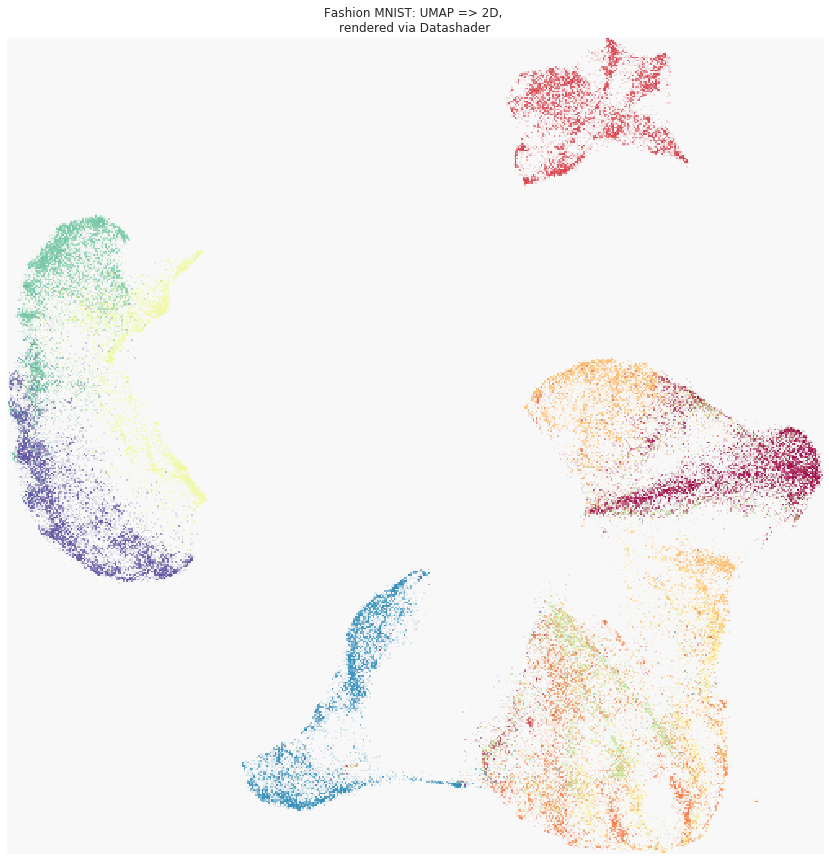

CPU times: user 1.12 s, sys: 9.05 ms, total: 1.13 s
Wall time: 1.17 s


In [4]:
%%time

# Plot via Datashader

df = pd.DataFrame(embedding, columns=('x', 'y'))
df['class'] = pd.Series([str(x) for x in target], dtype="category")

cvs = ds.Canvas(plot_width=500, plot_height=500)
agg = cvs.points(df, 'x', 'y', ds.count_cat('class'))
img = tf.shade(agg, color_key=color_key, how='eq_hist')

# JFT testing for bg color
#img = tf.set_background(img, '#c0c0c0')

ligth_gray = '#f8f8f8'

utils.export_image(img, filename='fashion-mnist', background='#f8f8f8')

image = plt.imread('fashion-mnist.png')
fig, ax = plt.subplots(figsize=(15, 15))

for spine in ax.spines.values():
  spine.set_edgecolor(ligth_gray)

plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Fashion MNIST: UMAP => 2D, \n"
          "rendered via Datashader",
          fontsize=12)

plt.show()

## Auto-use datashader

**TODO:** `umap.plot` is part of `umap-learn` 0.4. As of 2019-12-09, 0.4 is not final yet. As such, `umap.plot` is not installed on Colab. For now, just use the above technique to manually use datashader.

The 0.4 branch of umap-learn will enable:
```
import umap.plot
```
Which automatically uses datashader if there are enough points. That eliminates overplotting etc.

## Bokeh

Bokeh has a server (`bokeh serve` on the CLI) which would be great to have working with Datashader running on a Colab VM (See [Issue #61](https://github.com/reconstrue/single_cell_on_colab/issues/61)).

In [0]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()


In [6]:
N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x).astype(int), np.floor(30+2*y).astype(int))]

p = figure()
p.circle(x, y, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)
show(p)